# Import the modules

In [2]:
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
%matplotlib inline

# Import the data

In [71]:
DATA_FOLDER = 'Data/'
CHARACTER_DATASET = DATA_FOLDER + 'character.metadata.tsv'
NLP_DATASET = DATA_FOLDER + 'corenlp_plot_summaries.tar'
MOVIE_DATASET = DATA_FOLDER + 'Movie.metadata.tsv'
SUMMARIES_DATASET = DATA_FOLDER + 'plot_summaries.txt.gz'
DEFAULT_COMPRESSION = 'gzip'

In [72]:
def load_metadata(path, column_names, header=None, low_memory=False):
    return pd.read_table(path, header=header, names=column_names)

In [4]:
columns_character = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'Actor_gender', 'Actor_height_meters', 'Actor_ethnicity_Freebase_ID', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']
columns_movie = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue', 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres' ]

characters = load_metadata(CHARACTER_DATASET,column_names=columns_character)
movies = load_metadata(MOVIE_DATASET,column_names=columns_movie)

In [5]:
movies.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## Attempt to read corenlp dataset

In [3]:
DATA_FOLDER = 'Data/'
NLP_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries/'
test_file = '330.xml.gz'

In [4]:
test_df = pd.read_xml(NLP_FOLDER+test_file, compression='gzip')
test_df.head()

,sentences,coreference
0,NaN,NaN


In [21]:
import json
import xmltodict

with open(NLP_FOLDER+'330.txt.xml') as xml_file:
    data_dict = xmltodict.parse(xml_file.read())
    data_dict = data_dict
    
    # generate the object using json.dumps(=
    json_data = json.dumps(data_dict)
     
    # Write the json data to output
    with open("data.json", "w") as json_file:
        json_file.write(json_data)
        
#test_df = pd.read_json('data.json', orient='columns')
#test_df

# Cleaning

## Drop NaN values

In [7]:
characters = characters.dropna()
movies = movies.dropna()

## Problem of date

Typo in the release date of the movie, but this movie is not in characters

In [8]:
movies.loc[movies.Movie_release_date == '1010-12-02','Movie_release_date'] = '2010-12-02'

## Format of movie languages, genres and country

In [9]:
def format_multiple(chain,deb,step):
    res = chain.split('"')[deb::step]
    return res

In [10]:
movies.Movie_genres = movies.Movie_genres.apply(format_multiple,deb=3,step=4)
movies.Movie_countries = movies.Movie_countries.apply(format_multiple,deb=3,step=4)
movies.Movie_languages = movies.Movie_languages.apply(format_multiple,deb=3,step=4)

In [11]:
keys = ['Movie_languages','Movie_countries','Movie_genres']
for key in keys:
    nb = len(movies[movies[key].apply(len) == 0])
    print('{nb} movies without {key} ({percentage:.2f}% of the dataset)'.format(nb=nb,key=key, percentage=nb*100/len(movies)))

243 movies without Movie_languages (2.95% of the dataset)
75 movies without Movie_countries (0.91% of the dataset)
3 movies without Movie_genres (0.04% of the dataset)


## Format for dates

In [12]:
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='%Y-%m-%d').dt.year
characters.Movie_release_date = pd.to_datetime(characters.Movie_release_date,format='%Y-%m-%d').dt.year
characters.Actor_date_of_birth = pd.to_datetime(characters.Actor_date_of_birth,format='%Y-%m-%d').dt.year

# Visualisations

## Movies

<AxesSubplot: >

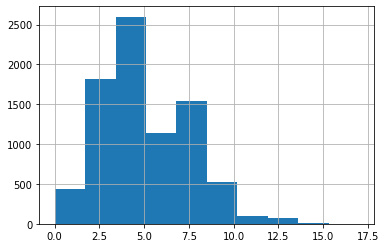

In [97]:
# nb film with ... genres
movies.Movie_genres.apply(len).hist()

In [48]:
movies_by_year = movies.groupby('Movie_release_date')
movies_by_year_std = movies_by_year.agg('std')
movies_by_year_mean = movies_by_year.agg('mean')
movies_by_year_median = movies_by_year.agg('median')
movies_by_year_min = movies_by_year.agg('min')
movies_by_year_max = movies_by_year.agg('max')

Text(0.5, 0.98, 'Evolution of average (1), median (2), minimal (3) and maximal (4) box office revenue')

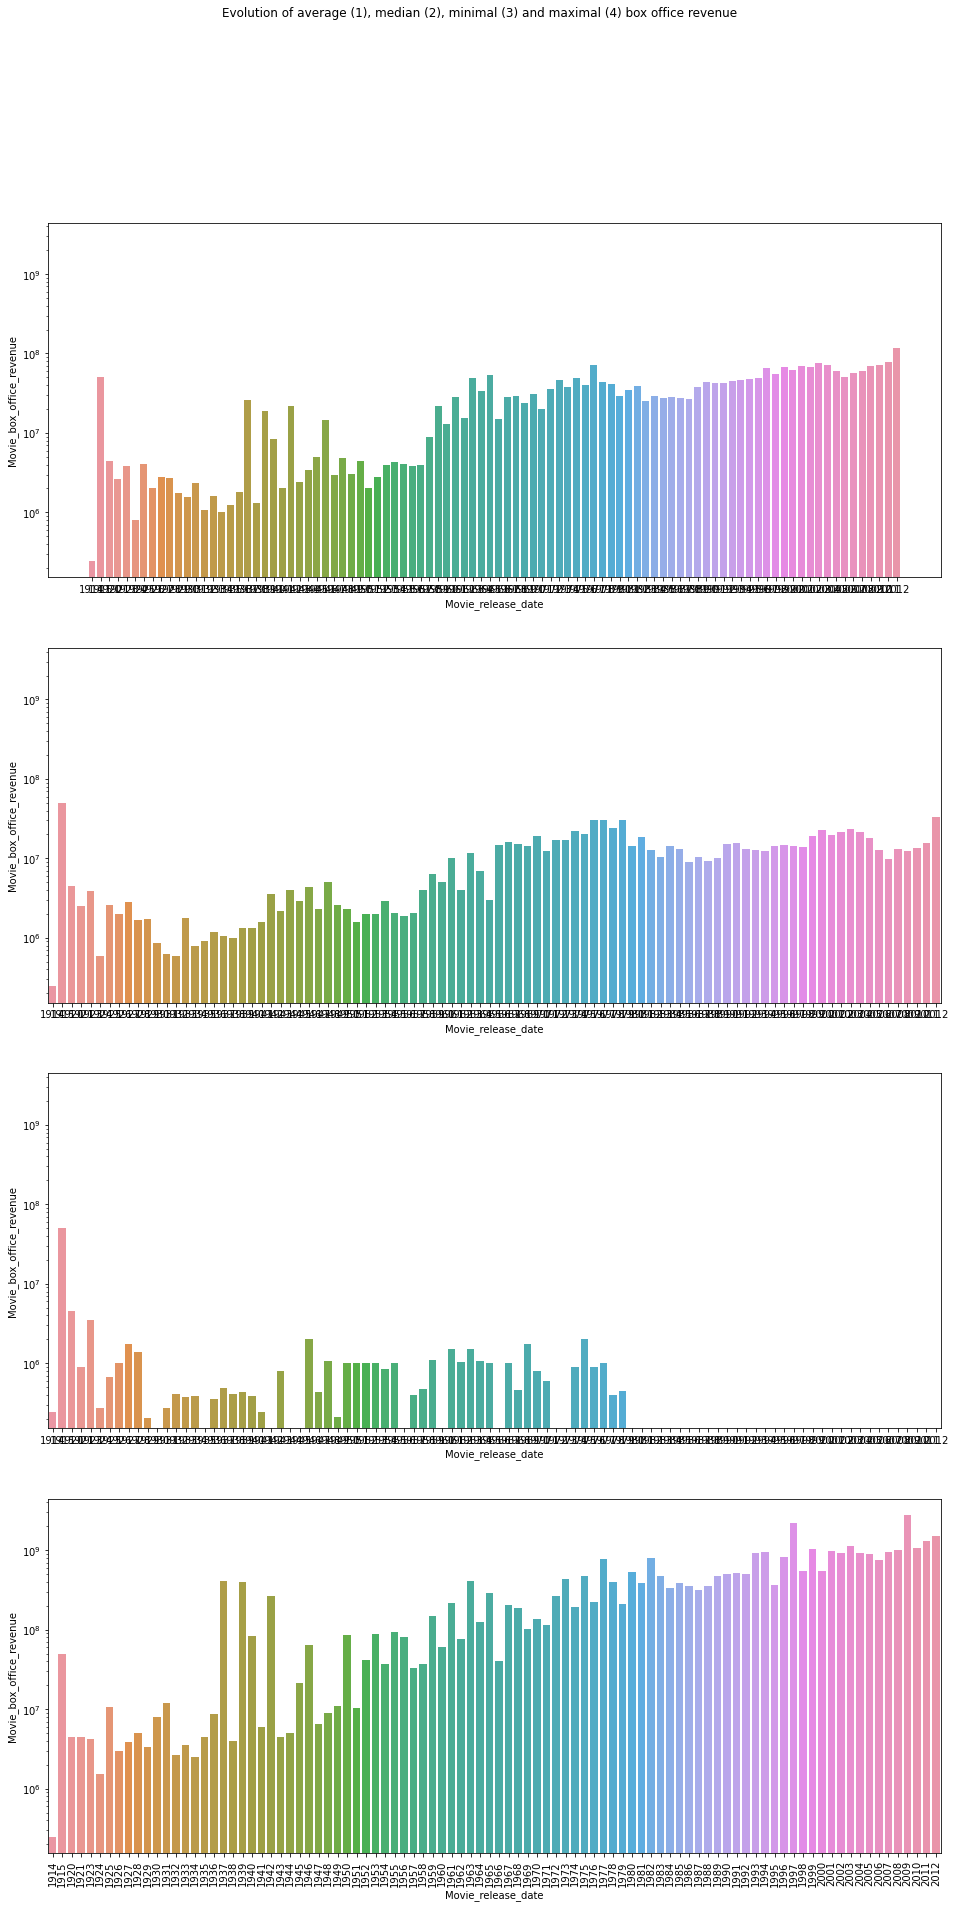

In [55]:
fig,axs = plt.subplots(4,1,figsize=(16,30),sharey=True)
sns.barplot(data = movies_by_year_mean, x=movies_by_year_mean.index, y='Movie_box_office_revenue', ax=axs[0])
axs[0].errorbar(range(len(movies_by_year_mean.index)), np.log(movies_by_year_mean.Movie_box_office_revenue), yerr=np.log(movies_by_year_std.Movie_box_office_revenue), fmt='none', capsize=5, zorder=1, color='C0')
sns.barplot(data = movies_by_year_median, x=movies_by_year_median.index, y='Movie_box_office_revenue', ax=axs[1])
sns.barplot(data = movies_by_year_min, x=movies_by_year_min.index, y='Movie_box_office_revenue', ax=axs[2])
sns.barplot(data = movies_by_year_max, x=movies_by_year_max.index, y='Movie_box_office_revenue', ax=axs[3])
plt.xticks(rotation=90)
plt.yscale('log')
plt.suptitle('Evolution of average (1), median (2), minimal (3) and maximal (4) box office revenue')

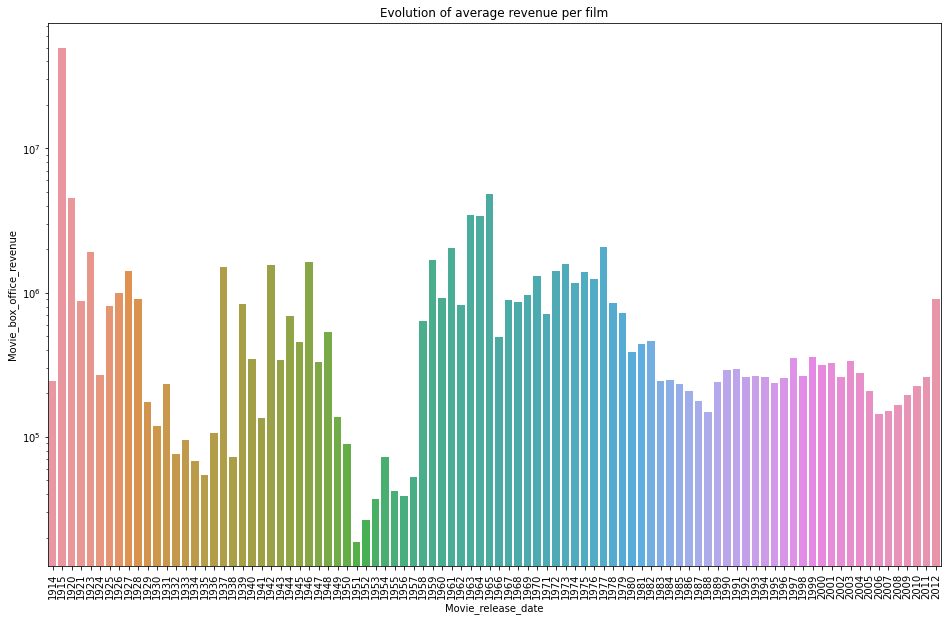

In [101]:
movies_by_year_count = movies_by_year.agg('count')
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(x=movies_by_year_mean.index, y=movies_by_year_mean.Movie_box_office_revenue/movies_by_year_count.Movie_box_office_revenue, ax=ax)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of average revenue per film')
pass

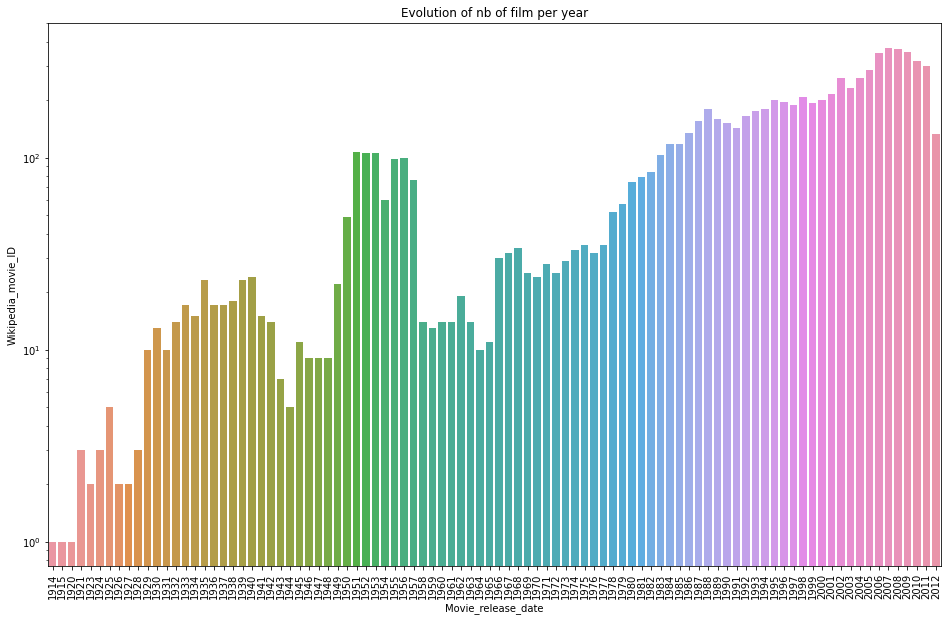

In [67]:
movies_by_year_count = movies_by_year.agg('count')
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(data=movies_by_year_count, x=movies_by_year_mean.index, y='Wikipedia_movie_ID', ax=ax)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of nb of film per year')
pass

In [104]:
movies[movies.Movie_release_date == 1915]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
2634,3333,/m/0151l,The Birth of a Nation,1915,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."


What we can say:
- number of films per year $\approx$ exponential growth
- outliers ++ (from min/max barplot, should boxplot to have a clearer view of it) -> prefer median or geometric mean than arithmetic mean
- average revenue per film very oscillatory -> not conclusive as a "baseline"

# Characters

In [125]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006,Taper Guy,1971,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999,Sandii,1975,F,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


Actor gender: 1 for female, 0 for male

In [13]:
characters.Actor_gender = pd.get_dummies(characters.Actor_gender)
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,1,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,0,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,1,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006,Taper Guy,1971,0,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999,Sandii,1975,1,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


In [14]:
characters_per_actor = characters.groupby('Actor_name')

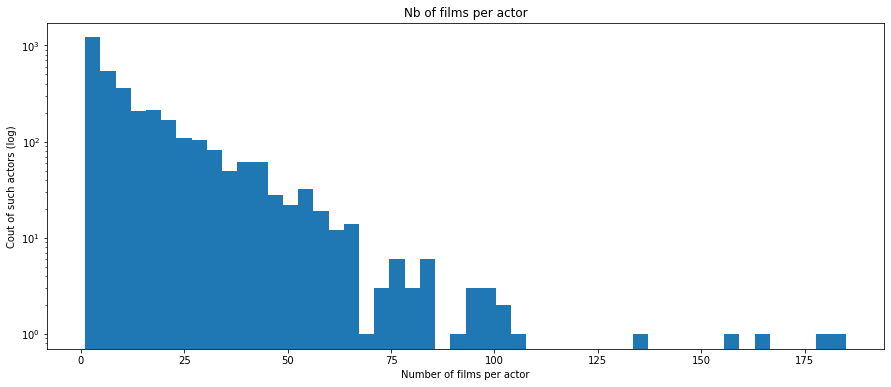

In [68]:
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_actor.agg('count').Wikipedia_movie_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of films per actor')
plt.xlabel('Number of films per actor')
plt.ylabel('Cout of such actors (log)')
None

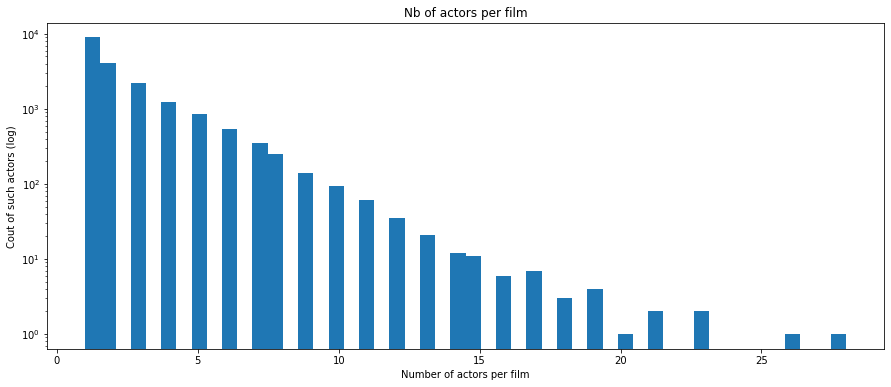

In [69]:
characters_per_film = characters.groupby('Wikipedia_movie_ID')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_film.agg('count').Freebase_actor_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of actors per film')
plt.xlabel('Number of actors per film')
plt.ylabel('Cout of such actors (log)')
None

In [17]:
ratio_F_M = characters[characters.Actor_gender == 1]['Freebase_actor_ID'].nunique()/characters[characters.Actor_gender == 0]['Freebase_actor_ID'].nunique()
nb_ethnicity = characters.Actor_ethnicity_Freebase_ID.nunique()
print('There are {percentage:.2f}% female actors in the dataset'.format(percentage=ratio_F_M*100))
print('There are {nb} different ethnicities'.format(nb=nb_ethnicity))

There are 78.69% female actors in the dataset
There are 320 different ethnicities


In [19]:
characters_by_year = characters.groupby('Movie_release_date')
characters_by_year_mean = characters_by_year.agg('mean')
characters_by_year_mean.head()

,Wikipedia_movie_ID,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_age_at_movie_release
Movie_release_date,,,,,
1919,17145476.0,1902.000000,1.000000,1.550,16.000000
1924,9817444.0,1905.000000,1.000000,1.702,18.000000
1925,16189151.0,1905.000000,1.000000,1.702,19.000000
1926,10817217.0,1905.333333,0.666667,1.766,20.166667
1927,15506939.5,1905.000000,0.500000,1.780,21.000000


Text(0.5, 1.0, 'Evolution of the fraction of women in the film (1=female, 0=male)')

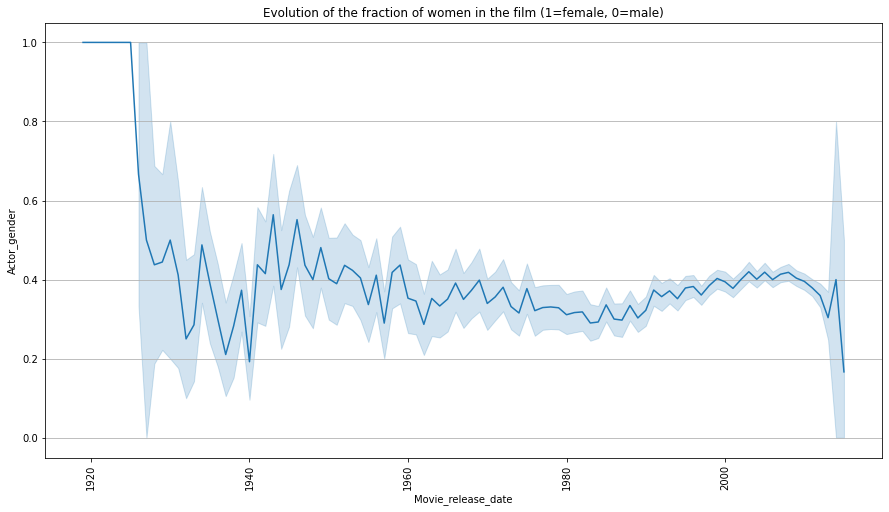

In [65]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_gender', ax=ax)
plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of women in the film (1=female, 0=male)')

Text(0.5, 1.0, 'Evolution of average age of the actor')

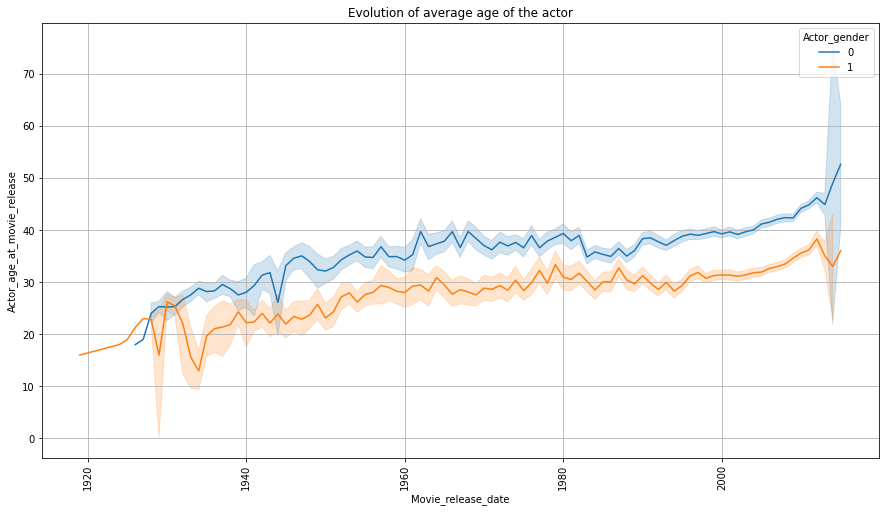

In [63]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_age_at_movie_release',hue='Actor_gender', ax=ax)
plt.grid(visible=True)
plt.xticks(rotation=90)
plt.title('Evolution of average age of the actor')

What xe can say:
- in average, fraction of women stable ($\approx 40%$)
- average age of actor increases, and male actors tend to be 8 years older (confirm by t-tests)
- we cannot really rely on nb of actors per film (lot of films with $\approx 2$ actors)